# Austin, TX Crime Analysis

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from census import Census
import gmaps
import requests
import json

%matplotlib inline

# usefuls.py
from usefuls import atx_zip_codes, zipcode_tabulation_area, similar_offense_type

# config.py not included on GitHub for obvious reasons
from config import gkey, census_key

# Configure gmaps
gmaps.configure(api_key=gkey)

## Get and clean data

### Get Property Data from Zillow
* The data file is too large to upload to GitHub, but it is obtainable from [here](https://www.kaggle.com/zillow/zecon#Zip_time_series.cs)

In [ ]:
# Read the file
zillow_df = pd.read_csv('Zip_time_series.csv')

# Rename RegionName to zipcode
zillow_df = zillow_df.rename(columns={'RegionName': 'Zip Code'})

# Filter out all non-Austin area zipcodes
zillow_df = zillow_df[[(z in atx_zip_codes) for z in zillow_df['Zip Code']]]

# Add year column to dataframe
zillow_df['year'] = zillow_df['Date'].apply(lambda s : int(s[:4]))

# Filter out all years before 2009
zillow_df = zillow_df[(zillow_df['year'] >= 2011) & (zillow_df['year'] <= 2016)]

# Keep only the columns we need
zillow_df = zillow_df[['year', 'Zip Code', 'ZHVI_AllHomes']]

# Drop NaN values
zillow_df = zillow_df.dropna()

# Group data by year, zipcode, find the mean ZHVI per year per zipcode
zillow_df = round(zillow_df.groupby(['year', 'Zip Code']).ZHVI_AllHomes.mean(),2).to_frame()

# Write to csv
zillow_df.to_csv('zillow_data.csv')

# Preview the frame
zillow_df.head()

### Get Austin Police Department crime data
* The csv file used is obtainable from [here](https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu)

In [ ]:
crime_df = pd.read_csv('Crime_Reports.csv')

# Filter out non greater Austin zip codes
crime_df = crime_df[crime_df['Zip Code'].isin(atx_zip_codes)]

# Extract only years from date
crime_df['year'] = crime_df['Occurred Date'].apply(lambda d : int(d[-4:]))

# Drop unnecessary columns
crime_df = crime_df[['Zip Code', 'year', 'Highest Offense Description']]

# Look at only years 2011-2016
crime_df = crime_df[(crime_df['year'] >= 2011) & (crime_df['year'] <= 2016)]

# Convert zip codes to integer type
crime_df['Zip Code'] = crime_df['Zip Code'].apply(lambda x: int(x))

# Combine similar offenses
crime_df["Highest Offense Description"] = crime_df["Highest Offense Description"].replace(similar_offense_type)

# Write to csv
crime_df.to_csv('crime_data.csv', index=False)

# Preview
crime_df.head()

### Get census data

In [ ]:
# Prepare dictionary of census data keyed by year
# We use what years are available: 2011 - 2016
# 2010 gives geography error; zipcode geography was not supported in that year
years = list(range(2011,2017))
# Census() results
cen = dict.fromkeys(years)
# cen.acs5.get() results
census_data = dict.fromkeys(years)
# Get census data
for y in years:
    cen[y] = Census(census_key, year=y)
    census_data[y] = cen[y].acs5.get(("B01003_001E"), {'for': zipcode_tabulation_area})

# Add year to each row-to-be
for y in years:
    for i, l in enumerate(census_data[y]):
            census_data[y][i]['year'] = y

# Convert census data to one dataframe
census_df = pd.DataFrame()
for y in years:
    census_df = census_df.append(pd.DataFrame(census_data[y]))

census_df = census_df.rename(columns={"B01003_001E": "Population", "zip code tabulation area": "Zip Code"})
# Convert population and Zip Code to integers
census_df['Zip Code'] = census_df['Zip Code'].apply(lambda x : int(x))
census_df['Population'] = census_df['Population'].apply(lambda x : int(x))

# Write to csv
census_df.to_csv('census_data.csv', index=False)

# Preview
census_df.head()

## Read above .csv files
* This is for development purposes so we don't have to reload and clean raw data files every time

In [2]:
zillow_df = pd.read_csv('zillow_data.csv')
crime_df = pd.read_csv('crime_data.csv')
census_df = pd.read_csv('census_data.csv')

In [3]:
zillow_df.head()

,year,Zip Code,ZHVI_AllHomes
0,2011,78610,167591.67
1,2011,78613,182450.00
2,2011,78617,104841.67
3,2011,78641,143600.00
4,2011,78664,130350.00


In [4]:
crime_df.head()

,Zip Code,year,Highest Offense Description
0,78701,2014,Burglary
1,78702,2015,Other
2,78759,2015,Motor Vehicle Theft
3,78741,2013,Burglary
4,78719,2016,Other


In [5]:
census_df.head()

,Population,year,Zip Code
0,22052,2011,78610
1,63901,2011,78613
2,18572,2011,78617
3,43655,2011,78641
4,4256,2011,78652


# Heat map of crime rates per zip code

## Step 1: Calculate crime rates
* Crimes rates being number of crimes per 100,000 people in a zip code

In [ ]:
rates_df = crime_df.groupby(['year', 'Zip Code'])['Highest Offense Description'].count().to_frame().rename(columns={'Highest Offense Description' : 'Reports'}).reset_index()

rates_df = rates_df.merge(census_df, on=['year', 'Zip Code'])

rates_df['Crime Rate'] = round(100_000 * rates_df['Reports'] / rates_df['Population'],1)

rates_df.head()

In [24]:
rates_df.to_csv('crime_rates.csv', index=False)

## Step 2: Get latitude and longitude for each zip code

In [7]:
# Set up dictionaries keyed by Austin zip codes
# For latitude and longitude, respectively
lat = dict.fromkeys(atx_zip_codes)
lng = dict.fromkeys(atx_zip_codes)

# Make API calls to find out latitude and longitude for each zip code
for zipcode in atx_zip_codes:
    base_url = 'https://maps.googleapis.com/maps/api/geocode/json?address={0}&key={1}'.format(zipcode, gkey)
    # Convert to JSON
    response = requests.get(base_url).json()
    # Extract lat/lng
    lat[zipcode] = response["results"][0]["geometry"]["location"]["lat"]
    lng[zipcode] = response["results"][0]["geometry"]["location"]["lng"]

# Add columns to dataframe for latitude and longitude
rates_df['Lat'] = rates_df['Zip Code'].apply(lambda z : lat[z])
rates_df['Lng'] = rates_df['Zip Code'].apply(lambda z : lng[z])

## Step 3: Set up and display heat map
* Note to self: Cannot get this to work so far. Shelving for now

In [9]:
fig = gmaps.figure()
# Create a heat layer
crime_zipcode = gmaps.heatmap_layer(rates_df[["Lat", "Lng"]].astype(float), weights= rates_df['Crime Rate'].astype(float), 
                                 dissipating=True, max_intensity=150000,
                                 point_radius = 30)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
crime_zipcode.dissipating = True
crime_zipcode.max_intensity = 150000
crime_zipcode.point_radius = 30

fig.add_layer(crime_zipcode)

fig

###### !!!!
## Code not complete, need to figure out how to get the figure to display first before I proceed forward

Figure(layout=FigureLayout(height='420px'))

# Percent Changes from 2011-2016

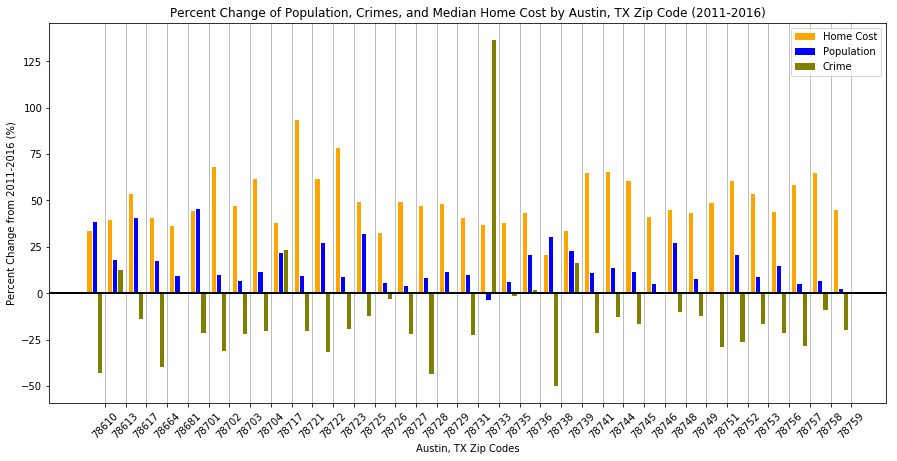

In [73]:
popcrime_df = pd.read_csv('crime_rates.csv')
home_df = pd.read_csv('zillow_data.csv')

hmask_2011 = [x == 2011 for x in home_df.year]
home_df_2011 = home_df[hmask_2011]

hmask_2016 = [x == 2016 for x in home_df.year]
home_df_2016 = home_df[hmask_2016]

merge_years_home = pd.merge(home_df_2011, home_df_2016, on="Zip Code")

merge_years_home['ZHVI_difference'] = merge_years_home['ZHVI_AllHomes_y'] - merge_years_home['ZHVI_AllHomes_x']

merge_years_home['ZHVI_percent_change'] = merge_years_home['ZHVI_difference'] / merge_years_home['ZHVI_AllHomes_x'] * 100

merge_years_home['ZHVI_percent_change'] = merge_years_home['ZHVI_percent_change'].round(2)

pcmask_2011 = [x == 2011 for x in popcrime_df.year]
popcrime_df_2011 = popcrime_df[pcmask_2011]

pcmask_2016 = [x == 2016 for x in popcrime_df.year]
popcrime_df_2016 = popcrime_df[pcmask_2016]

popcrime_df_2011 = popcrime_df_2011.drop(['Crime Rate'], axis=1)

popcrime_df_2016 = popcrime_df_2016.drop(['Crime Rate'], axis=1)

merge_years_popcrime = pd.merge(popcrime_df_2011, popcrime_df_2016, on="Zip Code")

merge_years_popcrime['population_difference'] = merge_years_popcrime['Population_y'] - merge_years_popcrime['Population_x']

merge_years_popcrime['#_of_crimes_difference'] = merge_years_popcrime['Reports_y'] - merge_years_popcrime['Reports_x']

merge_years_popcrime['population_percent_change'] = merge_years_popcrime['population_difference'] / merge_years_popcrime['Population_x'] * 100

merge_years_popcrime['population_percent_change'] = merge_years_popcrime['population_percent_change'].round(2)

merge_years_popcrime['crimes_percent_change'] = merge_years_popcrime['#_of_crimes_difference'] / merge_years_popcrime['Reports_x'] * 100

merge_years_popcrime['crimes_percent_change'] = merge_years_popcrime['crimes_percent_change'].round(2)

merge_years_popcrimecost = pd.merge(merge_years_popcrime, merge_years_home, on="Zip Code")

x_axis_1 = []
counter = 1
for i in range(0,37,1):
    x_axis_1.append(counter)
    counter += 4

x_axis_2 = []
counter = 2
for i in range(0,37,1):
    x_axis_2.append(counter)
    counter += 4

x_axis_3 = []
counter = 3
for i in range(0,37,1):
    x_axis_3.append(counter)
    counter += 4

ticks = []
counter = 4
for i in range(0,37,1):
    ticks.append(counter)
    counter += 4

perc_change_cost = merge_years_popcrimecost['ZHVI_percent_change']
perc_change_pop = merge_years_popcrimecost['population_percent_change']
perc_change_crime = merge_years_popcrimecost['crimes_percent_change']

zip_code_all = merge_years_popcrimecost['Zip Code']

# Create bars
plt.bar(x_axis_1, perc_change_cost, color='orange', alpha=1, label="Home Cost")
plt.bar(x_axis_2, perc_change_pop, color='blue', alpha=1, label="Population")
plt.bar(x_axis_3, perc_change_crime, color='olive', alpha=1, label="Crime")
 
# Create names on the x-axis
plt.xticks(ticks, zip_code_all, rotation=45)
plt.xlabel("Austin, TX Zip Codes")
plt.ylabel("Percent Change from 2011-2016 (%)")
plt.title("Percent Change of Population, Crimes, and Median Home Cost by Austin, TX Zip Code (2011-2016)")
plt.legend()

plt.axhline(0, color='black', linewidth=2)
plt.grid(axis='x')

fig = plt.gcf()
fig.set_size_inches(15,7)

plt.savefig('popcrimecostpercentchangeBARTEST.png')
# Show graphic
plt.show()

Overall, population and median home cost in Austin increased between 2011 and 2016.
There appears to be similarities in the rate of increase for both population and median home cost.
Overall, crime decreased across most of the Austin zip codes.
There is no visibile relationship between the crime and the median home cost